# GCN Algorithm Example 1

SEOYEON CHOI  
2023-01-11

> Our method; GNAR Dataset Example(fiveVTS, fiveNet)

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [3]:
%load_ext rpy2.ipython

In [225]:
%%R
library(GNAR)
library(igraph)

# 시간측정 방법

``` python
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1
```

# EbayesThresh

In [5]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-2,-1.5), runif(25,1.5,2), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
x_ebayes=signal+epsilon

In [6]:
%R -o x_ebayes
%R -o index_of_trueoutlier
%R -o signal

In [ ]:
%R -i 

------------------------------------------------------------------------

In [355]:
arr = np.array([1,2,3])

In [356]:
%R -i arr

In [357]:
%%R
arr

[1] 1 2 3

------------------------------------------------------------------------

In [7]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [8]:
outlier_true_index = index_of_trueoutlier

In [9]:
outlier_true_value = x_ebayes[index_of_trueoutlier]

In [10]:
outlier_true_one = signal.copy()

In [11]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

# 0. 데이터 가정

데이터가정: missing (결측값) 이 있는 자료를 가정

-   missing이 있는상태: ST-GCN 을 사용할 수 X $\to$ **코드에 에러는 나지
    않지만 yhat이 산출되지 않았습니다.**
-   missing이 없어야만: ST-GCN 을 사용할 수 O

# 예제 1 GNAR fiveVT

**증명 - missing이 있는상태: ST-GCN 을 사용할 수 X**

In [12]:
%%R
summary(fiveNet)

GNARnet with 5 nodes and 10 edges
 of equal length  1

In [13]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [14]:
%R -o fiveVTS
%R -o edges

-   node: 5
-   time 200

In [15]:
edges_tensor = torch.tensor(edges)

In [16]:
nonzero_indices = edges_tensor.nonzero()

In [17]:
fiveNet_edge = np.array(nonzero_indices).T

## 데이터 일부 missing 처리

### 1) Block 처리

#### \[1\] ST-GCN

In [18]:
%%R
fiveVTS0 <- fiveVTS
fiveVTS0[50:150, 3] <- NA

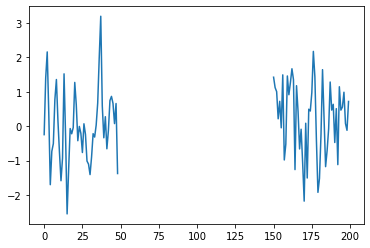

In [20]:
plt.plot(fiveVTS0[:,2])

In [228]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [229]:
f = torch.tensor(fiveVTS0).reshape(200,5,1).float()

In [230]:
X = f[:199,:,:]
y = f[1:,:,:]

In [231]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [232]:
_ee = enumerate(zip(X,y))

In [233]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.53it/s]

In [234]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

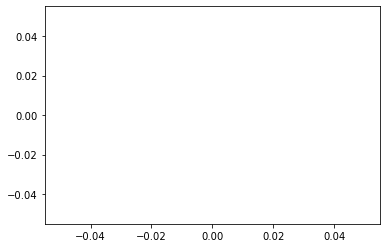

In [235]:
plt.plot(yhat[:,0].data)
plt.plot(yhat[:,1].data)
plt.plot(yhat[:,2].data)
plt.plot(yhat[:,3].data)

### 2) Random missing values

In [31]:
%%R
set.seed(1)
fiveVTSrandom <- fiveVTS
sampleindex = sort(sample(1:200, 100))
fiveVTSrandom[sampleindex,3] <- NA

In [32]:
%R -o fiveVTSrandom
%R -o sampleindex

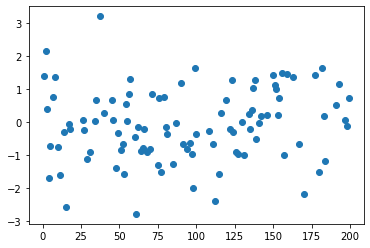

In [33]:
plt.plot(fiveVTSrandom[:,2],'o')

### 3) By 2

In [34]:
%%R
fiveVTStwo <- fiveVTS
indextwo <- rep(seq(1, by = 2, 200))
fiveVTStwo[indextwo, 3] <- NA

In [35]:
%R -o fiveVTStwo
%R -o indextwo

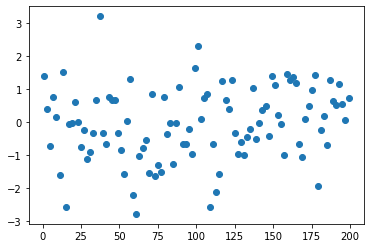

In [36]:
plt.plot(fiveVTStwo[:,2],'o')

# 1. missing을 채움. (mean, linear interpolation)

## 1.1. Mean

### 1) Block

In [37]:
fiveVTS0_mean = fiveVTS0.copy()

In [38]:
fiveVTS0_mean[49:150,2] = np.mean(fiveVTS0[:49,2].tolist()+fiveVTS0[150:,2].tolist())

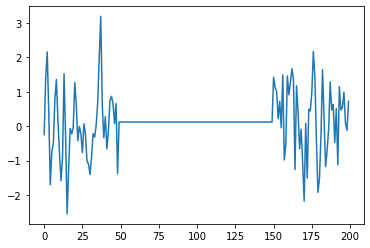

In [39]:
plt.plot(fiveVTS0_mean[:,2])

### 2) Random missing values

In [40]:
fiveVTSrandom_mean = fiveVTSrandom.copy()

In [41]:
df = pd.DataFrame(fiveVTSrandom[:,2])
mean_value = df.mean() # finds the mean value of the column A
df = df.fillna(mean_value) # replace missing values with the mean value

In [42]:
fiveVTSrandom_mean[:,2] = np.array(df).reshape(200,)

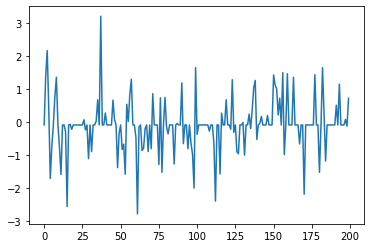

In [43]:
plt.plot(fiveVTSrandom_mean[:,2])

### 3) By 2

In [44]:
fiveVTStwo_mean = fiveVTStwo.copy()

In [45]:
df = pd.DataFrame(fiveVTStwo[:,2])
mean_value = df.mean() # finds the mean value of the column A
df = df.fillna(mean_value) # replace missing values with the mean value

In [46]:
fiveVTStwo_mean[:,2] = np.array(df).reshape(200,)

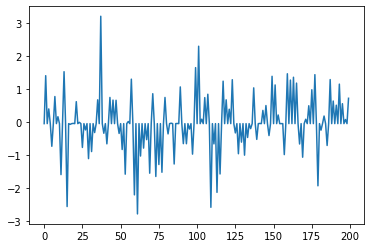

In [47]:
plt.plot(fiveVTStwo_mean[:,2])

## 1.2. linear interpolation

### 1) Block

In [48]:
fiveVTS0_linearinterpolation = fiveVTS0.copy()

In [49]:
# Sample data points
x = np.array([48,150])
y = np.array([fiveVTS0_linearinterpolation[48,2],fiveVTS0_linearinterpolation[150,2]])

# Create interpolating function
f = interp1d(x, y, kind='linear')

# Estimate y value for x = 2.5
y_interp = f(range(49,150))

In [50]:
fiveVTS0_linearinterpolation[49:150,2] = y_interp

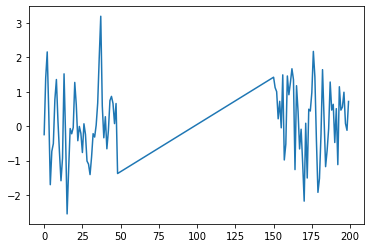

In [51]:
plt.plot(fiveVTS0_linearinterpolation[:,2])

### 2) Random missing values

In [52]:
fiveVTSrandom_linearinterpolation = fiveVTSrandom.copy()

In [53]:
_df = pd.DataFrame(fiveVTSrandom_linearinterpolation[:,2])
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [54]:
fiveVTSrandom_linearinterpolation[:,2] = np.array(_df).reshape(200,)

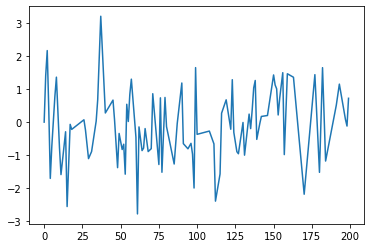

In [55]:
plt.plot(fiveVTSrandom_linearinterpolation[:,2])

### 3) By 2

In [56]:
fiveVTStwo_linearinterpolation = fiveVTStwo.copy()

In [57]:
_df = pd.Series(fiveVTStwo_linearinterpolation[:,2])
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [58]:
fiveVTStwo_linearinterpolation[:,2] = _df

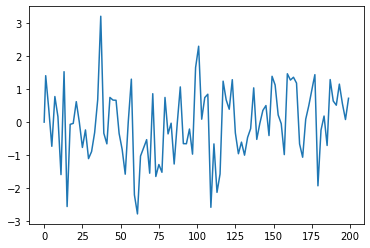

In [59]:
plt.plot(fiveVTStwo_linearinterpolation[:,2])

# 2. ST-GCN 을 사용하여 fhat을 구함. (스무딩1)

In [70]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [71]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

GNAR이랑 비교 - MSE 등 평가지표

## 2.1. Mean

### 1) Block

In [72]:
f_mean = torch.tensor(fiveVTS0_mean).reshape(200,5,1).float()

In [73]:
X_mean = f_mean[:199,:,:]
y_mean = f_mean[1:,:,:]

In [74]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_mean,y_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

In [75]:
fhat_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_mean]).detach().numpy()

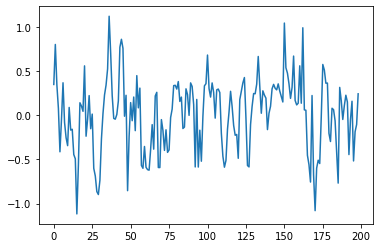

In [76]:
plt.plot(fhat_mean[:,2].data)

### 2) Random missing values

In [77]:
f_fiveVTSrandom_mean = torch.tensor(fiveVTSrandom_mean).reshape(200,5,1).float()

In [78]:
X_fiveVTSrandom_mean = f_fiveVTSrandom_mean[:199,:,:]
y_fiveVTSrandom_mean = f_fiveVTSrandom_mean[1:,:,:]

In [79]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTSrandom_mean,y_fiveVTSrandom_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

In [80]:
fhat_fiveVTSrandom_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTSrandom_mean]).detach().numpy()

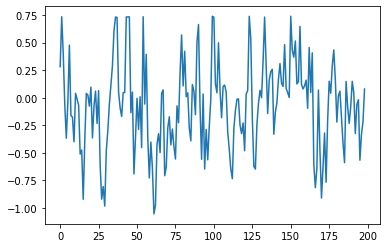

In [81]:
plt.plot(fhat_fiveVTSrandom_mean[:,2].data)

### 3) By 2

In [82]:
f_fiveVTStwo_mean = torch.tensor(fiveVTStwo_mean).reshape(200,5,1).float()

In [83]:
X_fiveVTStwo_mean = f_fiveVTStwo_mean[:199,:,:]
y_fiveVTStwo_mean = f_fiveVTStwo_mean[1:,:,:]

In [84]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTStwo_mean,y_fiveVTStwo_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.54it/s]

In [85]:
fhat_fiveVTStwo_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTStwo_mean]).detach().numpy()

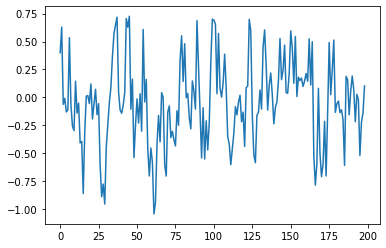

In [86]:
plt.plot(fhat_fiveVTStwo_mean[:,2].data)

## 2.2. linear interpolation

### 1) Block

In [87]:
f_linearinterpolation = torch.tensor(fiveVTS0_linearinterpolation).reshape(200,5,1).float()

In [88]:
X_linearinterpolation = f_linearinterpolation[:199,:,:]
y_linearinterpolation = f_linearinterpolation[1:,:,:]

In [89]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_linearinterpolation,y_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

In [90]:
fhat_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_linearinterpolation]).detach().numpy()

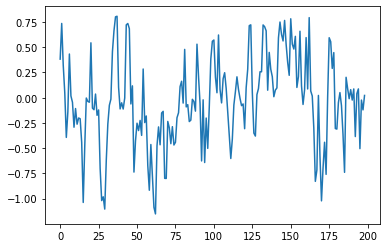

In [91]:
plt.plot(fhat_linearinterpolation[:,2].data)

### 2) Random missing values

In [92]:
f_fiveVTSrandom_linearinterpolation = torch.tensor(fiveVTSrandom_linearinterpolation).reshape(200,5,1).float()

In [93]:
X_fiveVTSrandom_linearinterpolation = f_fiveVTSrandom_linearinterpolation[:199,:,:]
y_fiveVTSrandom_linearinterpolation = f_fiveVTSrandom_linearinterpolation[1:,:,:]

In [94]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTSrandom_linearinterpolation,y_fiveVTSrandom_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

In [95]:
fhat_fiveVTSrandom_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTSrandom_linearinterpolation]).detach().numpy()

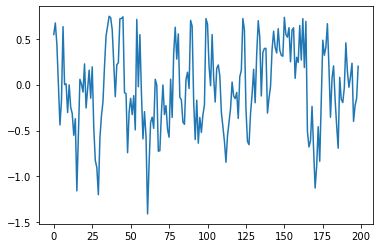

In [96]:
plt.plot(fhat_fiveVTSrandom_linearinterpolation[:,2].data)

### 3) By 2

In [97]:
f_fiveVTStwo_linearinterpolation = torch.tensor(fiveVTStwo_linearinterpolation).reshape(200,5,1).float()

In [98]:
X_fiveVTStwo_linearinterpolation = f_fiveVTSrandom_linearinterpolation[:199,:,:]
y_fiveVTStwo_linearinterpolation = f_fiveVTSrandom_linearinterpolation[1:,:,:]

In [99]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTStwo_linearinterpolation,y_fiveVTStwo_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

In [100]:
fhat_fiveVTStwo_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTStwo_linearinterpolation]).detach().numpy()

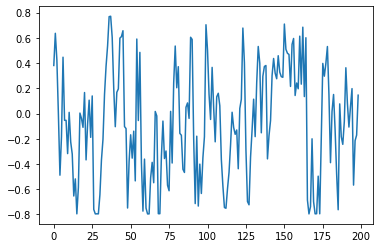

In [101]:
plt.plot(fhat_fiveVTStwo_linearinterpolation[:,2].data)

## 2.3. 원래 f

In [314]:
f = torch.tensor(fiveVTS).reshape(200,5,1).float()

In [315]:
X = f[:199,:,:]
y = f[1:,:,:]

In [316]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

In [317]:
fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

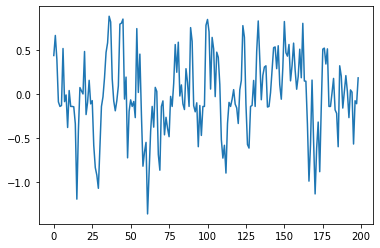

In [318]:
plt.plot(fhat_fiveVTS[:,2].data)

# 3. 2에서 얻은 fhat을 이용하여 그래프퓨리에변환+Ebayesthresh (스무딩2)

-   그래프퓨리에변환을 하는 가중치
-   년도끼리 이어주어서 하나의 큰 그래프로 만든뒤에 GFT
-   Ebayesthresh

## 3.1. Mean

### 3.1.1. Temporal

#### 1) Block

In [117]:
w=np.zeros((5,199,199))

In [118]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [119]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_mean[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_mean_temporal = fhatbarhat.reshape(199,-1)

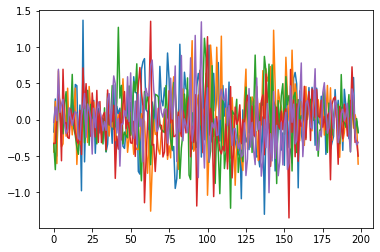

In [120]:
plt.plot(fhatbarhat_mean_temporal[:,0])
plt.plot(fhatbarhat_mean_temporal[:,1])
plt.plot(fhatbarhat_mean_temporal[:,2])
plt.plot(fhatbarhat_mean_temporal[:,3])
plt.plot(fhatbarhat_mean_temporal[:,4])

#### 2) Random missing values

In [121]:
w=np.zeros((5,199,199))

In [122]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [123]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTSrandom_mean[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_random_mean_temporal = fhatbarhat.reshape(199,-1)

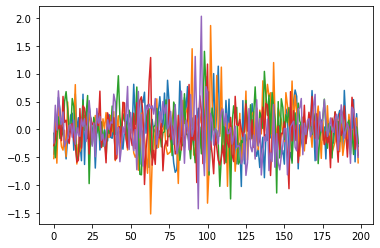

In [124]:
plt.plot(fhatbarhat_random_mean_temporal[:,0])
plt.plot(fhatbarhat_random_mean_temporal[:,1])
plt.plot(fhatbarhat_random_mean_temporal[:,2])
plt.plot(fhatbarhat_random_mean_temporal[:,3])
plt.plot(fhatbarhat_random_mean_temporal[:,4])

#### 3) By 2

In [125]:
w=np.zeros((5,199,199))

In [126]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [127]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTStwo_mean[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_twomean_temporal = fhatbarhat.reshape(199,-1)

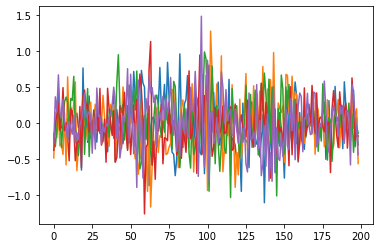

In [128]:
plt.plot(fhatbarhat_twomean_temporal[:,0])
plt.plot(fhatbarhat_twomean_temporal[:,1])
plt.plot(fhatbarhat_twomean_temporal[:,2])
plt.plot(fhatbarhat_twomean_temporal[:,3])
plt.plot(fhatbarhat_twomean_temporal[:,4])

### 3.1.2. Spatio

#### 1) Block

In [129]:
w=np.zeros((5,5))

In [130]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [131]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_mean.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio = fhatbarhat.reshape(199,-1)

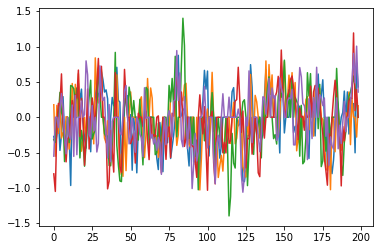

In [132]:
plt.plot(fhatbarhat_mean_spatio[:,0])
plt.plot(fhatbarhat_mean_spatio[:,1])
plt.plot(fhatbarhat_mean_spatio[:,2])
plt.plot(fhatbarhat_mean_spatio[:,3])
plt.plot(fhatbarhat_mean_spatio[:,4])

#### 2) Random missing values

In [133]:
w=np.zeros((5,5))

In [134]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [135]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_mean.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_mean_spatio = fhatbarhat.reshape(199,-1)

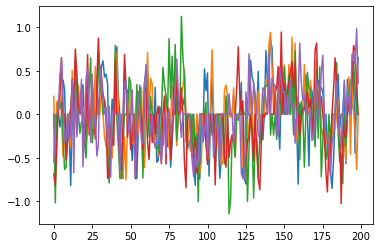

In [136]:
plt.plot(fhatbarhat_random_mean_spatio[:,0])
plt.plot(fhatbarhat_random_mean_spatio[:,1])
plt.plot(fhatbarhat_random_mean_spatio[:,2])
plt.plot(fhatbarhat_random_mean_spatio[:,3])
plt.plot(fhatbarhat_random_mean_spatio[:,4])

#### 3) By 2

In [137]:
w=np.zeros((5,5))

In [138]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [139]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_mean.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_mean_spatio = fhatbarhat.reshape(199,-1)

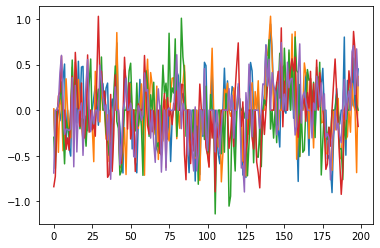

In [140]:
plt.plot(fhatbarhat_two_mean_spatio[:,0])
plt.plot(fhatbarhat_two_mean_spatio[:,1])
plt.plot(fhatbarhat_two_mean_spatio[:,2])
plt.plot(fhatbarhat_two_mean_spatio[:,3])
plt.plot(fhatbarhat_two_mean_spatio[:,4])

### 3.1.3. Spatio-Temporal

#### 1) Block

In [141]:
w=np.zeros((995,995))

In [142]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [143]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_mean.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(199,5,1)

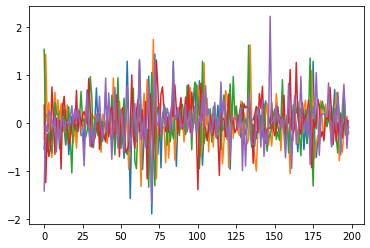

In [144]:
plt.plot(fhatbarhat_mean_spatio_temporal[:,0])
plt.plot(fhatbarhat_mean_spatio_temporal[:,1])
plt.plot(fhatbarhat_mean_spatio_temporal[:,2])
plt.plot(fhatbarhat_mean_spatio_temporal[:,3])
plt.plot(fhatbarhat_mean_spatio_temporal[:,4])

#### 2) Random missing values

In [145]:
w=np.zeros((995,995))

In [146]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [147]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_mean.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_mean_spatio_temporal = fhatbarhat.reshape(199,5,1)

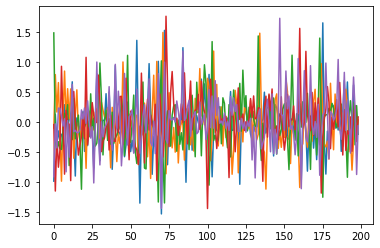

In [148]:
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,0])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,1])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,2])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,3])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,4])

#### 3) By 2

In [149]:
w=np.zeros((995,995))

In [150]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [151]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_mean.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_mean_spatio_temporal = fhatbarhat.reshape(199,5,1)

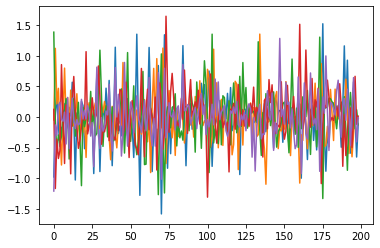

In [152]:
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,0])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,1])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,2])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,3])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,4])

## 3.2.linear interpolation

### 3.2.1. Temporal

#### 1) Block

In [153]:
w=np.zeros((5,199,199))

In [154]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [155]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])
fhatbar = np.hstack([Psi[i] @ fhat_linearinterpolation[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_linearinterpolation_temporal = fhatbarhat.reshape(199,-1)

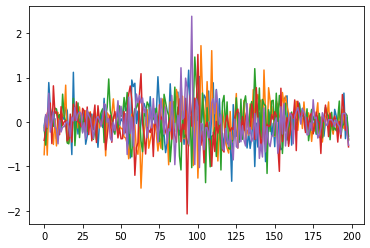

In [156]:
plt.plot(fhatbarhat_linearinterpolation_temporal[:,0])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,1])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,2])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,3])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,4])

#### 2) Random missing values

In [157]:
w=np.zeros((5,199,199))

In [158]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [159]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTSrandom_linearinterpolation[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_random_linearinterpolation_temporal = fhatbarhat.reshape(199,-1)

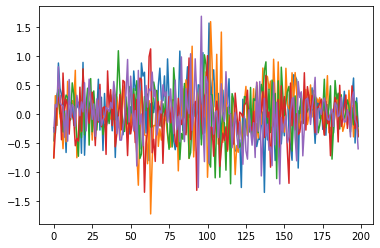

In [160]:
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,0])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,1])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,2])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,3])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,4])

#### 3) By 2

In [161]:
w=np.zeros((5,199,199))

In [162]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [163]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTStwo_linearinterpolation[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_two_linearinterpolation_temporal = fhatbarhat.reshape(199,-1)

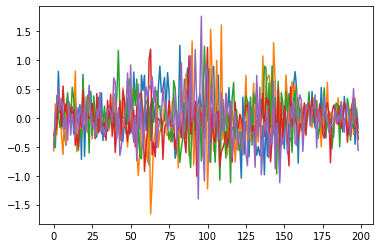

In [164]:
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,0])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,1])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,2])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,3])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,4])

### 3.2.2. Spatio

#### 1) Block

In [165]:
w=np.zeros((5,5))

In [166]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [167]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_linearinterpolation.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linearinterpolation_spatio = fhatbarhat.reshape(199,-1)

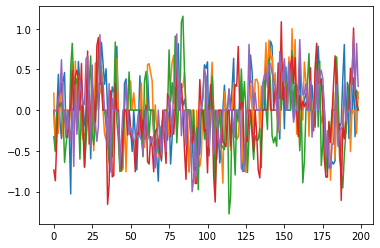

In [168]:
plt.plot(fhatbarhat_linearinterpolation_spatio[:,0])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,1])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,2])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,3])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,4])

#### 2) Random missing values

In [169]:
w=np.zeros((5,5))

In [170]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [171]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_linearinterpolation.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_linearinterpolation_spatio = fhatbarhat.reshape(199,-1)

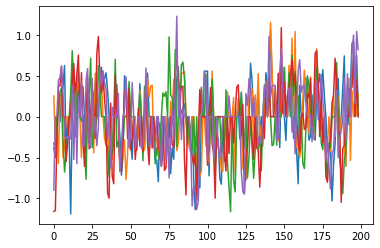

In [172]:
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,0])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,1])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,2])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,3])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,4])

#### 3) By 2

In [173]:
w=np.zeros((5,5))

In [174]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [175]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_linearinterpolation.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_linearinterpolation_spatio = fhatbarhat.reshape(199,-1)

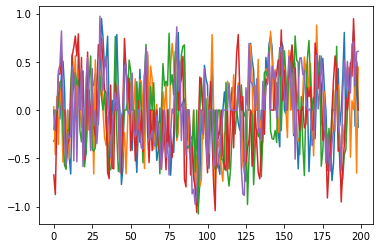

In [176]:
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,0])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,1])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,2])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,3])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,4])

### 3.2.3. Spatio-Temporal

#### 1) Block

In [177]:
w=np.zeros((995,995))

In [178]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [179]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_linearinterpolation.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_linearinterpolation_spatio_temporal = fhatbarhat.reshape(199,5,1)

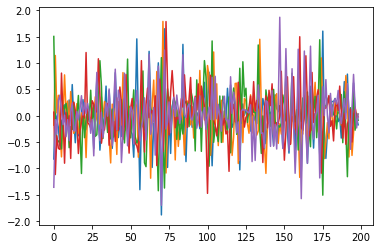

In [180]:
plt.plot(fhat_linearinterpolation_spatio_temporal[:,0])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,1])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,2])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,3])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,4])

#### 2) Random missing values

In [181]:
w=np.zeros((995,995))

In [182]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [183]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_linearinterpolation.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_random_linearinterpolation_spatio_temporal = fhatbarhat.reshape(199,5,1)

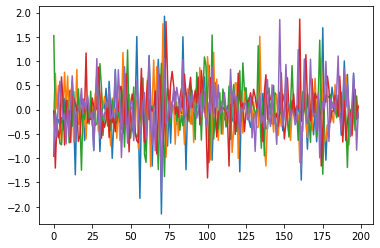

In [184]:
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,0])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,1])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,2])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,3])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,4])

#### 3) By 2

In [185]:
w=np.zeros((995,995))

In [186]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [187]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_linearinterpolation.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_two_linearinterpolation_spatio_temporal = fhatbarhat.reshape(199,5,1)

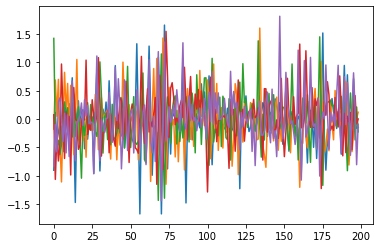

In [188]:
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,0])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,1])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,2])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,3])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,4])

## 3.3. original

#### 1) Temporal

In [326]:
w=np.zeros((5,199,199))

In [327]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [328]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTS[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_temporal = fhatbarhat.reshape(199,-1)

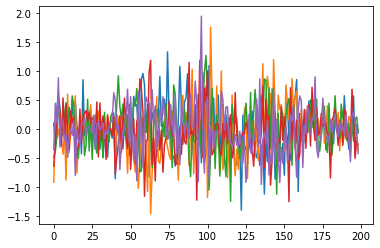

In [329]:
plt.plot(fhatbarhat_temporal[:,0])
plt.plot(fhatbarhat_temporal[:,1])
plt.plot(fhatbarhat_temporal[:,2])
plt.plot(fhatbarhat_temporal[:,3])
plt.plot(fhatbarhat_temporal[:,4])

#### 2) Spatio

In [330]:
w=np.zeros((5,5))

In [331]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [332]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTS.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_spatio = fhatbarhat.reshape(199,-1)

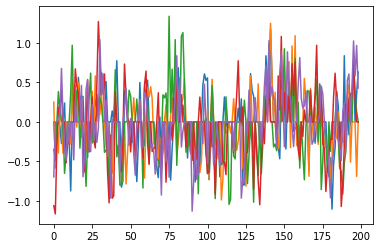

In [333]:
plt.plot(fhatbarhat_spatio[:,0])
plt.plot(fhatbarhat_spatio[:,1])
plt.plot(fhatbarhat_spatio[:,2])
plt.plot(fhatbarhat_spatio[:,3])
plt.plot(fhatbarhat_spatio[:,4])

#### 3) Spatio-Temporal

In [336]:
w=np.zeros((995,995))

In [337]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [338]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTS.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_spatio_temporal = fhatbarhat.reshape(199,5,1)

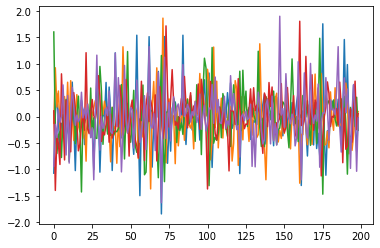

In [339]:
plt.plot(fhat_spatio_temporal[:,0])
plt.plot(fhat_spatio_temporal[:,1])
plt.plot(fhat_spatio_temporal[:,2])
plt.plot(fhat_spatio_temporal[:,3])
plt.plot(fhat_spatio_temporal[:,4])

# 4. 1로 돌아가서 반복

# Original f 진행한 것과 비교

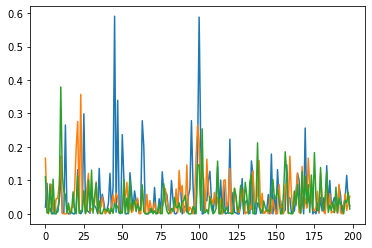

In [346]:
plt.plot((fhatbarhat_temporal[:,2] - fhatbarhat_mean_temporal[:,2])**2)
plt.plot((fhatbarhat_temporal[:,2] - fhatbarhat_random_mean_temporal[:,2])**2)
plt.plot((fhatbarhat_temporal[:,2] - fhatbarhat_twomean_temporal[:,2])**2)

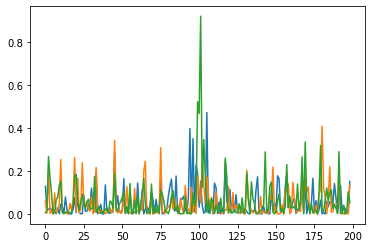

In [347]:
plt.plot((fhatbarhat_temporal[:,2] - fhatbarhat_linearinterpolation_temporal[:,2])**2)
plt.plot((fhatbarhat_temporal[:,2] - fhatbarhat_random_linearinterpolation_temporal[:,2])**2)
plt.plot((fhatbarhat_temporal[:,2] - fhatbarhat_two_linearinterpolation_temporal[:,2])**2)

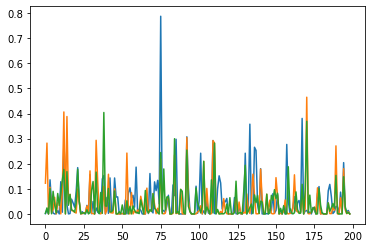

In [348]:
plt.plot((fhatbarhat_spatio[:,2] - fhatbarhat_mean_spatio[:,2])**2)
plt.plot((fhatbarhat_spatio[:,2] - fhatbarhat_random_mean_spatio[:,2])**2)
plt.plot((fhatbarhat_spatio[:,2] - fhatbarhat_two_mean_spatio[:,2])**2)

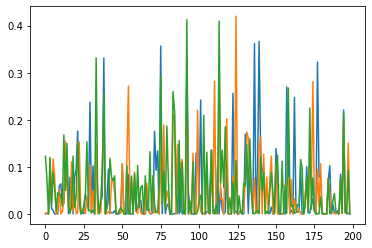

In [349]:
plt.plot((fhatbarhat_spatio[:,2] - fhatbarhat_linearinterpolation_spatio[:,2])**2)
plt.plot((fhatbarhat_spatio[:,2] - fhatbarhat_random_linearinterpolation_spatio[:,2])**2)
plt.plot((fhatbarhat_spatio[:,2] - fhatbarhat_two_linearinterpolation_spatio[:,2])**2)

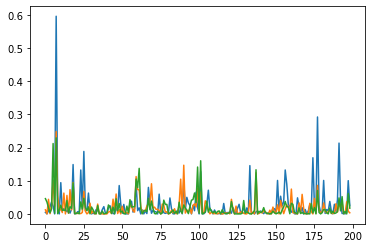

In [350]:
plt.plot((fhat_spatio_temporal[:,2] - fhatbarhat_mean_spatio_temporal[:,2])**2)
plt.plot((fhat_spatio_temporal[:,2] - fhatbarhat_random_mean_spatio_temporal[:,2])**2)
plt.plot((fhat_spatio_temporal[:,2] - fhatbarhat_two_mean_spatio_temporal[:,2])**2)

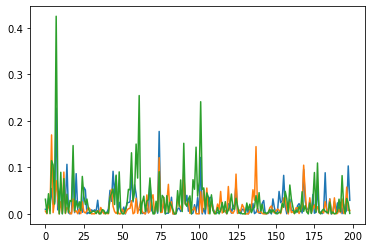

In [351]:
plt.plot((fhat_spatio_temporal[:,2] - fhat_linearinterpolation_spatio_temporal[:,2])**2)
plt.plot((fhat_spatio_temporal[:,2] - fhat_random_linearinterpolation_spatio_temporal[:,2])**2)
plt.plot((fhat_spatio_temporal[:,2] - fhat_two_linearinterpolation_spatio_temporal[:,2])**2)